In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns



ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [1]:
# Function to read in and detect facial images. 
def load_detect_faces(path):
    images = []
    labels = []
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            print(f"{label}") # check order of dir entry. 
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y + h, x:x + w] 
                        images.append(face_region)
                        labels.append(label)
    return images, labels  # I moved the return outside the loop


In [4]:
def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        img = cv2.equalizeHist(image)
        preprocessed_images.append(img)
    return preprocessed_images

In [5]:

def hog_feature_extraction(images):
    hog_features = []
    for image in images:
        image = cv2.resize(image, (64, 64)) # use 64 for more detail/pixels. 32 only produced 0.5 accuracy. 
        hog_feature = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(hog_feature)
    return np.array(hog_features)
    

In [6]:
train_folder_path = "JAFFE-[70,30]/train/"
test_folder_path = "JAFFE-[70,30]/test/"

In [7]:
# Load and process the data
X_train, y_train = load_detect_faces(train_folder_path)
X_test, y_test = load_detect_faces(test_folder_path)

X_train = preprocess_images(X_train) # pre-processing training data enhances accuracy. 

class_distribution_jaffe = Counter(y_train) # calculate the number of images for each class in training data (class imbalance).
class_distribution_jaffe_test = Counter(y_test) # calculate the number of images for each class in test data.

# show the class imbalance
print(class_distribution_jaffe)
print(class_distribution_jaffe_test)

X_train_features = hog_feature_extraction(X_train)
X_test_features = hog_feature_extraction(X_test)

# Build and train the SVM model

svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=7, gamma='scale'))
svm.fit(X_train_features, y_train)

# Test the model
y_pred = svm.predict(X_test_features)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

                    

Angry
Fear
Happy
Neutral
Sad
Surprise
Angry
Fear
Happy
Neutral
Sad
Surprise
Counter({'Fear': 22, 'Happy': 22, 'Sad': 22, 'Neutral': 21, 'Surprise': 21, 'Angry': 20})
Counter({'Fear': 10, 'Angry': 9, 'Happy': 9, 'Neutral': 9, 'Sad': 9, 'Surprise': 9})
Accuracy: 0.8181818181818182
Confusion Matrix:
 [[ 9  0  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 0  3  6  0  0  0]
 [ 0  3  0  6  0  0]
 [ 0  1  0  0  8  0]
 [ 0  3  0  0  0  6]]


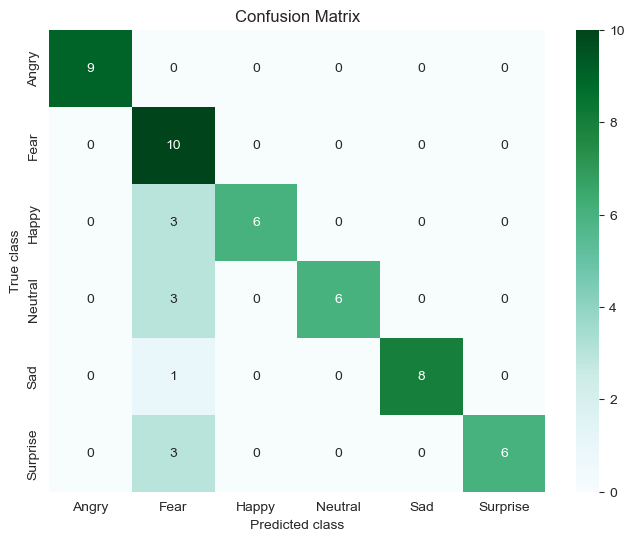

In [8]:
class_labels = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


confusion_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='BuGn', xticklabels=class_labels, yticklabels=class_labels)

plt.title("Confusion Matrix")

plt.xlabel("Predicted class")

plt.ylabel("True class")

plt.show()

In [9]:
def extract_face_hog(img):
    img = cv2.resize(img, (64, 64))
    hog_features, hog_image = hog(img, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2),
                                  block_norm='L2-Hys', visualize=True)
    return hog_features, hog_image

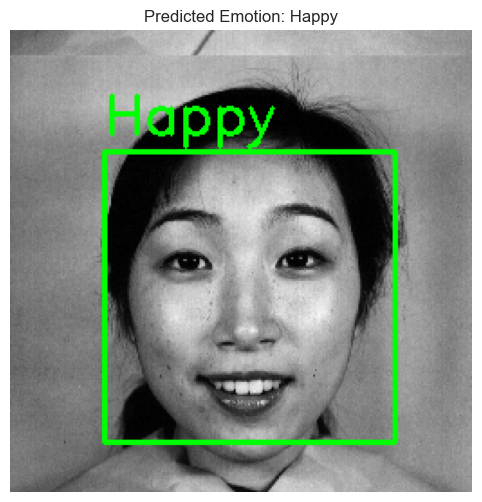

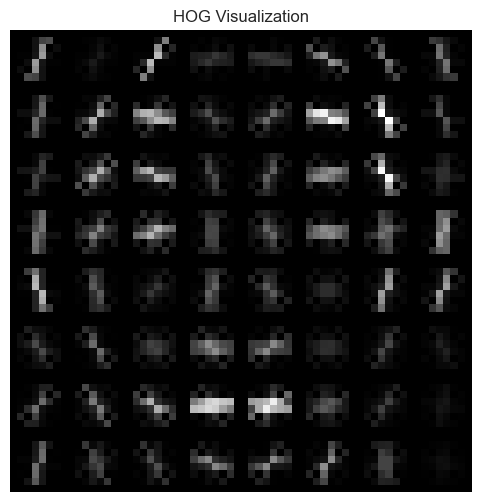

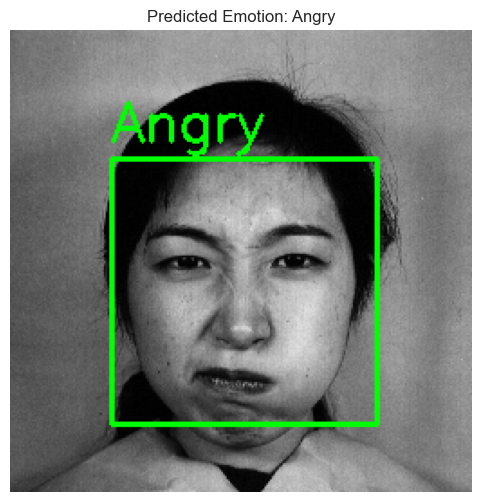

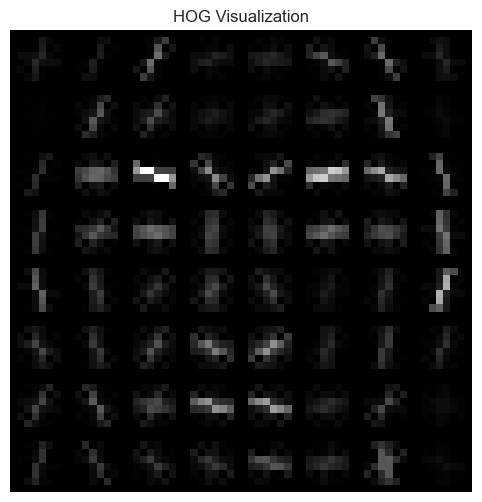

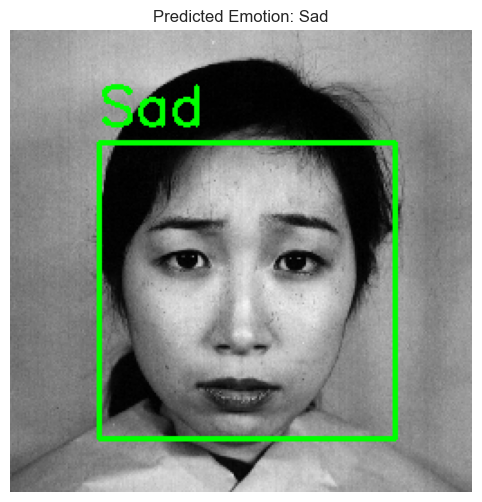

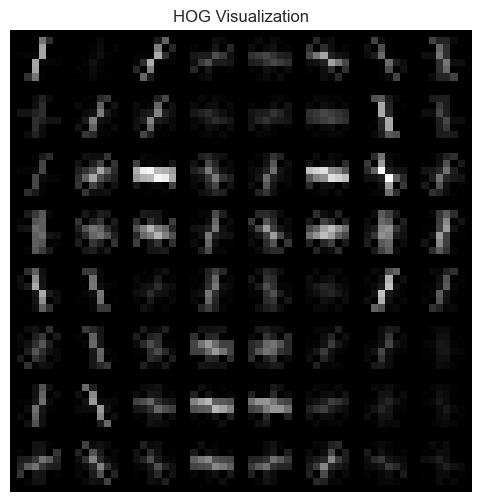

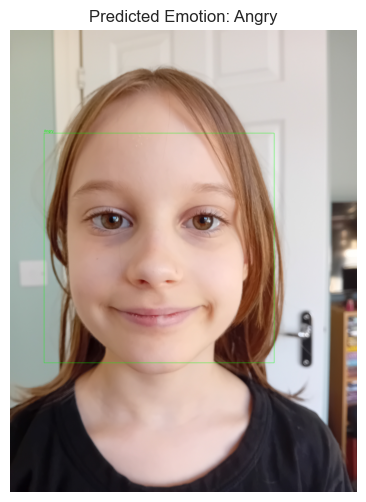

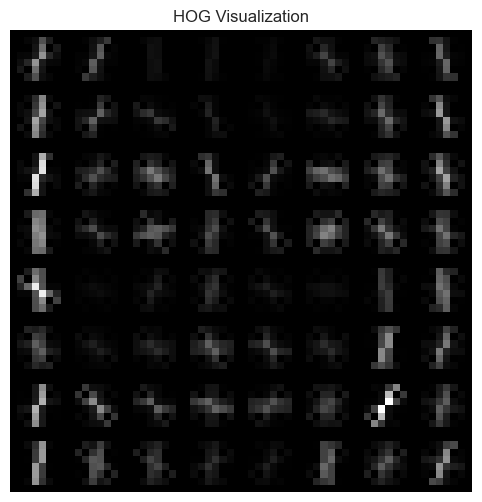

In [10]:
def predict_emotion(img_path, model):
    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image cannot be read.")
    
    # Convert to grayscale
    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(grey_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        raise ValueError("No faces detected.") 
    
    for (x, y, w, h) in faces:
        # Extract face region
        face_region = grey_img[y:y + h, x:x + w]
        
        # Extract HOG features
        hog_features, hog_image = extract_face_hog(face_region)
        hog_features = hog_features.reshape(1, -1)
        
        # Predict emotion
        pred_emotion = model.predict(hog_features)[0]
        
        # Visualise the results
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box around face
        cv2.putText(img_rgb, pred_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Show the image with predictions
        plt.figure(figsize=(10, 6))
        plt.imshow(img_rgb)
        plt.title(f"Predicted Emotion: {pred_emotion}")
        plt.axis("off")
        plt.show()
        
        # show the HOG visualisation
        plt.figure(figsize=(10, 6))
        plt.imshow(hog_image, cmap='gray')
        plt.title("HOG Visualization")
        plt.axis("off")
        plt.show()

        
# pick the first image from three emotion categories.       
test_image_angry = "KA.AN1.39.tiff"
test_image_happy = "KA.HA1.29.tiff"  
test_image_sad = "KA.SA1.33.tiff"

ephra_img = "ephra.jpg" 



predict_emotion(test_image_happy, svm)
predict_emotion(test_image_angry, svm)
predict_emotion(test_image_sad, svm)
predict_emotion(ephra_img, svm)




    